In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .
!pip install -e .[notebooks]


Cloning into 'sam3'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 619 (delta 23), reused 18 (delta 9), pack-reused 579 (from 1)
Receiving objects: 100% (619/619), 58.95 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 86.8 MB/s eta 0:00:00
  Building editable for sam3 (pyproject.toml) ... d

Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB

In [1]:
!pip install pyefd

In [1]:
import sys
sys.path.append('/content/sam3')

In [2]:
import torch
import scipy
#################################### For Image ####################################
from PIL import Image
import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)
# Load an image



/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [3]:
def get_masks(path):
  image = Image.open(path)
  inference_state = processor.set_image(image)
  # Prompt the model with text
  output = processor.set_text_prompt(state=inference_state, prompt="humans")
  # Get the masks, bounding boxes, and scores
  return image, output["masks"].cpu().numpy()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def show_masks(image, masks):
  l = []
  for mask in masks:
    label3 = np.stack([mask[0],mask[0],mask[0]], axis=2)
    l.append(image * label3)
  for i in l:
    plt.imshow(i)
    plt.show()
def show_mask(image, mask):
  label3 = np.stack([mask[0],mask[0],mask[0]], axis=2)
  r = image * label3
  plt.imshow(r)
  plt.show()


In [5]:
# @title

from bz2 import compress
from typing import Any, Callable, Optional

import numpy as np
import torch
from torch import Tensor
from torch import nn as nn
from torchvision.utils import make_grid


FFT_MEASURE_MAX = np.sqrt(np.power(0.5, 2) + np.power(0.5, 2))




def compression_measure(
    np_img,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:

    np_img_bytes = np_img.tobytes()
    compressed = compress(np_img_bytes)

    complexity = len(compressed) / len(np_img_bytes)

    if fill_ratio_norm:
        fill_ratio = np_img.sum().item() / np.ones_like(np_img).sum().item()
        return complexity * (1 - fill_ratio), None

    return complexity, None


def fft_measure(np_img):

    np_img_2d = np_img.squeeze() # Ensure the image is 2D
    fft = np.fft.fft2(np_img_2d)

    fft_abs = np.abs(fft)

    n_h, n_w = fft.shape  # Get both height (n_h) and width (n_w) dimensions

    pos_f_idx_h = n_h // 2
    pos_f_idx_w = n_w // 2

    df_h = np.fft.fftfreq(n=n_h)  # Frequencies for height dimension
    df_w = np.fft.fftfreq(n=n_w)  # Frequencies for width dimension

    # Sum of amplitudes in the positive frequency quadrant
    amplitude_sum = fft_abs[:pos_f_idx_h, :pos_f_idx_w].sum()

    if amplitude_sum == 0:
        return 0.0, None # Avoid division by zero

    # Calculate mean frequencies
    # For x-frequency, broadcast df_w across rows
    mean_x_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w] * df_w[:pos_f_idx_w]).sum() / amplitude_sum
    # For y-frequency, broadcast df_h across columns
    mean_y_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w].T * df_h[:pos_f_idx_h]).T.sum() / amplitude_sum

    mean_freq = np.sqrt(np.power(mean_x_freq, 2) + np.power(mean_y_freq, 2))

    # mean frequency in range 0 to np.sqrt(0.5^2 + 0.5^2)
    return mean_freq / FFT_MEASURE_MAX, None


def vae_reconstruction_measure(
    img: Tensor,
    model_gb: nn.Module,
    model_lb: nn.Module,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:
    model_gb.eval()
    model_lb.eval()

    with torch.no_grad():
        mask = img.to(model_gb.device)  # type: ignore

        recon_gb: Tensor
        recon_lb: Tensor

        recon_gb, _, _ = model_gb(mask)
        recon_lb, _, _ = model_lb(mask)

        abs_px_diff = (recon_gb - recon_lb).abs().sum().item()

        complexity = abs_px_diff / mask.sum()

        if fill_ratio_norm:
            complexity *= mask.sum().item() / torch.ones_like(mask).sum().item()

        return (
            complexity,
            make_grid(
                torch.stack(
                    [mask[0], recon_gb.view(-1, 64, 64), recon_lb.view(-1, 64, 64)]
                ).cpu(),
                nrow=1,
                padding=0,
            ),
        )


def combined_complexity(mask):
  return (compression_measure(mask)[0] + 0.025*fft_measure(mask)[0])*100

In [13]:
from typing_extensions import final
from pyefd import elliptic_fourier_descriptors
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import numpy
from functools import wraps
from time import time
from math import atan2, pi


def find_contours(mask):

    # Ensure the mask is a single-channel binary image (0 or 1)
    processed_mask = np.asarray(mask).squeeze()
    if processed_mask.ndim == 3 and processed_mask.shape[-1] == 3:
        # If it's a 3-channel image, take the first channel
        processed_mask = processed_mask[:, :, 0]
    processed_mask = processed_mask.astype(np.uint8)


    contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return []
    largest_contour = max(contours, key=cv2.contourArea)
    return [np.vstack(contours)] # Return as a list containing only the largest contour

def get_elliptic_fourier_descriptors_complexity(skimage_masks, skimage_masks2):

  # Get contours for the selected masks
  contours1 = []
  contours2 = []
  complexity1 = []
  complexity2 = []

  for mask in skimage_masks:
      l_contours = find_contours(mask)
      complexity1.append(combined_complexity(mask))
      if l_contours:
          contours1.extend(l_contours)
  for mask in skimage_masks2:
      l_contours = find_contours(mask)
      complexity2.append(combined_complexity(mask))
      if l_contours:
        contours2.extend(l_contours)

  # Check if contours were found
  if contours1 and contours2:
      # Calculate elliptic Fourier descriptors for the found contours
      coeffs1 = []
      coeffs2 = []
      for contour in contours1:

          if(len(contour.squeeze())>2):
            coeffs1.append(elliptic_fourier_descriptors(contour.squeeze(), order=5, normalize=True))
      for contour in contours2:
          if(len(contour.squeeze())>2):
            coeffs2.append(elliptic_fourier_descriptors(contour.squeeze(), order=5, normalize=True))
  else:
      print("Could not find contours in one or both masks.")

  return coeffs1, coeffs2, complexity1, complexity2


# --- Complexity Calculation ---

In [14]:
# @title
def get_distance(coeffs1, coeffs2, complexity1, complexity2, eomt=False):

  coeffsfiltered1 =[]
  coeffsfiltered2 =[]

  print(len(coeffs1))
  for j in range(len(coeffs1)):
    l = []

    if complexity1[j]>0.74 or eomt:

      for i in coeffs1[j]:

        a = np.array(i)

        a[np.abs(a)<0.01]=0

        l.append(a)
      coeffsfiltered1.append((np.concatenate(l, axis=0), j))
  for j in range(len(coeffs2)):
    l = []

    if complexity2[j]>0.74 or eomt:
      for i in coeffs2[j]:
        a = np.array(i)
        a[np.abs(a)<0.005]=0


        l.append(a)
      coeffsfiltered2.append((np.concatenate(l, axis=0),j))
  if not coeffsfiltered1:
    l=[]
    for i in coeffs1[complexity1.index(max(complexity1))]:
      a = np.array(i)

      a[np.abs(a)<0.005]=0

      l.append(a)
    coeffsfiltered1.append((np.concatenate(l, axis=0), j))
  if not coeffsfiltered2:
    l=[]
    for i in coeffs2[complexity2.index(max(complexity2))]:
      a = np.array(i)

      a[np.abs(a)<0.01]=0

      l.append(a)
    coeffsfiltered2.append((np.concatenate(l, axis=0), j))
  dist = []
  for i in coeffsfiltered1:
    for j in coeffsfiltered2:
      dist.append((np.linalg.norm(i[0]-j[0]),i[1], j[1]))

  return sorted(dist)




2
0.06282116745286706


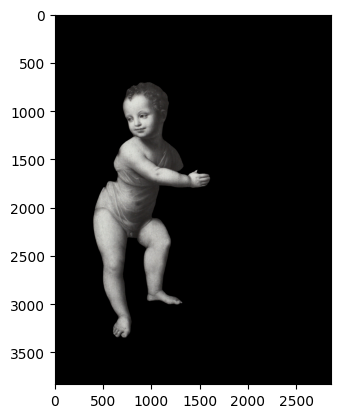

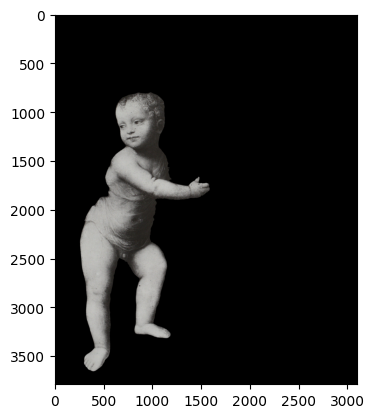

5
0.2428950109077155


False

In [15]:
from torch._C import ComplexType
from scipy import ndimage
def compare_two_images(image1link, image2link, eomt=False):

  image1, masks1 = get_masks(image1link)
  image2, masks2 = get_masks(image2link)
  image_left  = Image.open(image1link)
  image_right = Image.open(image2link)


  coeffs1, coeffs2, complexity1, complexity2 = get_elliptic_fourier_descriptors_complexity(masks1, masks2)

  dist = get_distance(coeffs1, coeffs2, complexity1, complexity2, eomt)
  if dist :

    print(dist[0][0])

    if dist[0][0]<0.13:
      show_mask(image1, masks1[dist[0][1]])
      show_mask(image2, masks2[dist[0][2]])
      return True

  return False

compare_two_images("images/image.jpg", "images/image2.jpg")
compare_two_images("images/image3.jpg", "images/image4.jpg")


1
0.4659613197667184
1
0.21054852942092464
1
0.49816817186850154
1
0.24094060669528558
1
0.40946526467782274
1
0.37366378625012026
1
0.4693107071031039
2
0.4230162729990327
2
0.48290507204236494
2
0.49384930406730215
2
0.38563765750636475
2
0.3269655877822722
2
0.062491933732095474


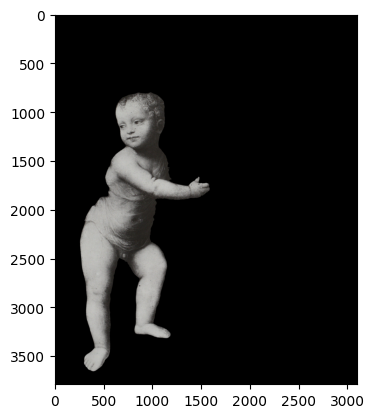

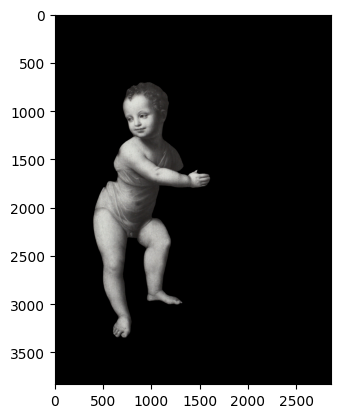

7
0.44898697419730293
7
0.1615250627718499
7
0.4096388064047537
7
0.345090963480836
7
0.39221077362854134
4
0.41273423303266343
4
0.4626776098030493
4
0.44966805075595595
4
0.5042360906158719
5
0.47570114183502404
5
0.40298293334678115
5
0.3021516154602959
2
0.13992965623551973
2
0.4862383411885869
3
0.4325692085204494
1


In [16]:
import os
def compare_image_set(path, eomt = False):
  files = os.listdir(path)
  files = [file for file in files if file.endswith(".jpg")]
  k=0
  for i in range(len(files)):
    for j in range(i+1, len(files)):
      if compare_two_images(path+files[i], path+files[j], eomt=eomt):
        k+=1
  print(k)
compare_image_set("images/")

In [ ]:
!git clone https://github.com/facebookresearch/dinov3.git



Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 538 (delta 199), reused 99 (delta 99), pack-reused 176 (from 1)
Receiving objects: 100% (538/538), 9.88 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.1 MB/s eta 0:00:00


In [ ]:
# @title
import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import torchmetrics
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

In [ ]:
# @title
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16" # We use this one
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# IMPORTANT: PLEASE CLONE THE DINOV3 REPOSITORY LOCALLY AND DOWNLOAD THE WEIGHTS MANUALLY

# we take DINOv3 ViT-L
MODEL_NAME = MODEL_DINOV3_VITL
LOCAL_REPO_PATH = "dinov3"
WEIGHT_PATH = "/content/drive/MyDrive/nflteams/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" # Needs to be requested from Meta (no automatic download)

model = torch.hub.load(
    repo_or_dir=LOCAL_REPO_PATH,
    model=MODEL_NAME,
    source="local",
    weights=WEIGHT_PATH
)
model.cuda()
print(f"Model {MODEL_NAME} loaded successfully.")

Downloading: "file:///content/drive/MyDrive/nflteams/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


100%|██████████| 1.13G/1.13G [00:21<00:00, 55.8MB/s]


Model dinov3_vitl16 loaded successfully.


In [ ]:
%ls

dinov3/  drive/  images/  sam3/  sample_data/


/tmp/ipython-input-1603092251.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_alpha = Image.fromarray(alpha, mode="L")
/tmp/ipython-input-1603092251.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_alpha_inv = Image.fromarray(255 - alpha, mode="L")


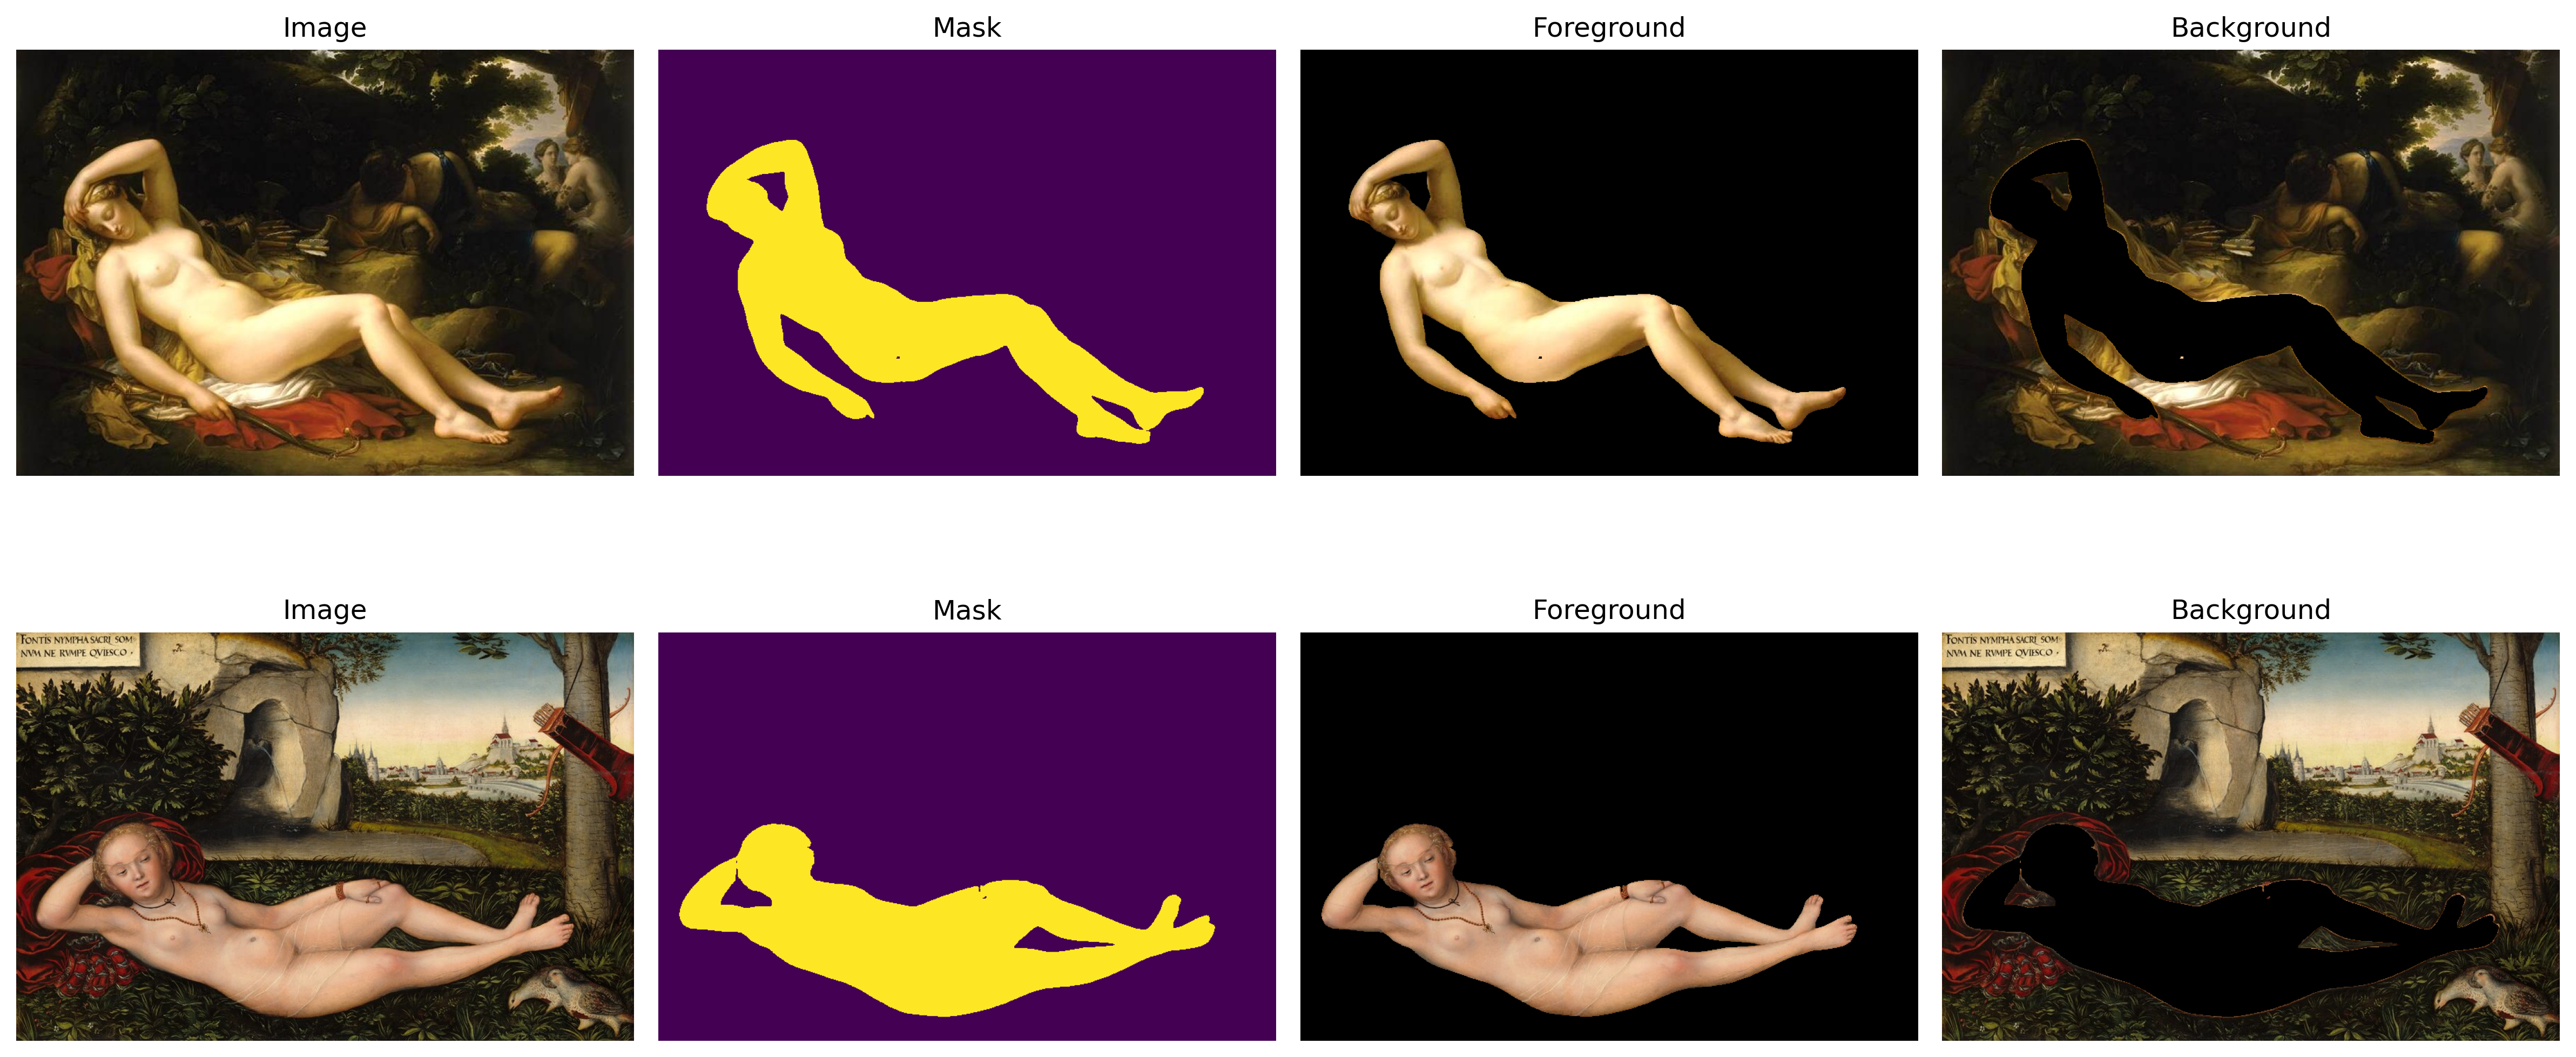

In [ ]:
plt.figure(figsize=(16, 8), dpi=300)

for j, (image, mask) in enumerate([(image_left, m1), (image_right, m2)]):
    # We needed to convert
    mask_np = np.array(mask[0])

    if mask_np.ndim == 2:
        # Already single-channel
        alpha = mask_np
    elif mask_np.ndim == 3 and mask_np.shape[2] == 4:
        # RGBA: take alpha channel
        alpha = mask_np[:, :, 3]
    elif mask_np.ndim == 3 and mask_np.shape[2] == 3:
        # RGB: use intensity (any non-zero considered foreground)
        alpha = mask_np.mean(axis=2)
    else:
        raise ValueError(f"Unsupported mask shape: {mask_np.shape}")

    # Normalize to uint8 [0, 255]
    alpha = np.asarray(alpha)

    if alpha.dtype != np.uint8:
        # Scale arbitrary numeric mask to [0, 255]
        max_val = alpha.max() if alpha.max() != 0 else 1
        alpha = (alpha.astype(np.float32) / max_val * 255).astype(np.uint8)
    else:
        # Handle binary 0/1 masks
        max_val = alpha.max()
        if max_val == 1:
            alpha = alpha * 255
        # If max is 0 or 255, we're fine

    # Create PIL 'L' masks
    mask_alpha = Image.fromarray(alpha, mode="L")
    mask_alpha_inv = Image.fromarray(255 - alpha, mode="L")

    # Background color (here black / transparent black)
    if image.mode == "RGBA":
        bg_color = (0, 0, 0, 0)
    elif image.mode == "RGB":
        bg_color = (0, 0, 0)
    else:
        bg_color = 0

    bg = Image.new(image.mode, image.size, bg_color)

    # We use the composite function to apply the alpha mask -> foreground and background
    foreground = Image.composite(image, bg, mask_alpha)
    background = Image.composite(image, bg, mask_alpha_inv)

    data_to_show = [image, mask.squeeze(), foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]

    for i, img in enumerate(data_to_show):
        plt.subplot(2, len(data_to_show), 4 * j + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

In [ ]:
def stratify(image_left, image_right, m1, m2):

  m1 = Image.fromarray(m1[0])
  m2 = Image.fromarray(m2[0])

  # quantization filter for the given patch size
  patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
  patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))
  IMAGENET_MEAN = (0.485, 0.456, 0.406)
  IMAGENET_STD = (0.229, 0.224, 0.225)

  MODEL_TO_NUM_LAYERS = {
      MODEL_DINOV3_VITS: 12,
      MODEL_DINOV3_VITSP: 12,
      MODEL_DINOV3_VITB: 12,
      MODEL_DINOV3_VITL: 24,
      MODEL_DINOV3_VITHP: 32,
      MODEL_DINOV3_VIT7B: 40,
  }

  n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

  patch_mask_values = []
  patch_features = []

  with torch.inference_mode():
      with torch.autocast(device_type='cuda', dtype=torch.float32):
          for image, mask in tqdm([(image_left, m1), (image_right, m2)], desc="Processing images"):
              # processing mask
              mask = mask.split()[-1]
              mask_resized = resize_transform(mask)
              #mask_quantized = patch_quant_filter(mask_resized).squeeze().view(-1).detach().cpu()
              mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
              patch_mask_values.append(mask_quantized)
              # processing image
              image = image.convert('RGB')
              image_resized = resize_transform(image)
              image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
              image_resized = image_resized.unsqueeze(0).cuda()

              feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
              dim = feats[-1].shape[1]
              #patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
              patch_features.append(feats[-1].squeeze().detach().cpu())
  MASK_FG_THRESHOLD = 0.7

  patch_features[0] = F.normalize(patch_features[0], p=2, dim=0)
  patch_features[1] = F.normalize(patch_features[1], p=2, dim=0)

  heatmaps = torch.einsum(
      "k f, f h w -> k h w",
      patch_features[0].view(dim, -1).permute(1, 0),
      patch_features[1],
  )

  # compute 2D patch locations in the left image
  n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]
  patch_indices_left = torch.arange(n_patches_left)
  locs_2d_left = (
      torch.stack(
          (
              patch_indices_left // patch_features[0].shape[2],  # row
              patch_indices_left % patch_features[0].shape[2]    # column
          ),
          dim=-1
      ) + 0.5
  ) * PATCH_SIZE

  # compute the corresponding 2D patch locations in the right image
  patch_indices_right = torch.flatten(heatmaps, start_dim=-2).argmax(dim=-1)
  locs_2d_right = (
      torch.stack(
          (
              patch_indices_right // patch_features[1].shape[2],  # row
              patch_indices_right % patch_features[1].shape[2]    # column
          ),
          dim=-1
      ) + 0.5
  ) * PATCH_SIZE

  # foreground patches mask in the left image
  patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)
  # left image patches mask for patches that map to a foreground patch in the right image
  patches_right_fg_selection = (patch_mask_values[1].view(-1)[patch_indices_right] > MASK_FG_THRESHOLD)
  # select foreground left image patches that map to foreground right image patches
  patches_fg_selection = (patches_left_fg_selection * patches_right_fg_selection)

  # select (row, col) coordinates for the matched patches
  locs_2d_left_fg = locs_2d_left[patches_fg_selection, :]
  locs_2d_right_fg = locs_2d_right[patches_fg_selection, :]
  pca = PCA(n_components=3, whiten=True)
  fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_fg_selection]
  pca.fit(fg_patches_left)
  # get colors for the left image
  h_patches_left = patch_features[0].shape[1]
  w_patches_left = patch_features[0].shape[2]
  x_left = patch_features[0].view(dim, -1).permute(1, 0)
  projected_image_left = torch.from_numpy(
      pca.transform(x_left.numpy())
  ).view(h_patches_left, w_patches_left, 3)
  # multiply by 2.0 and pass through a sigmoid to get vibrant colors
  projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)

  # get colors for the right image
  h_patches_right = patch_features[1].shape[1]
  w_patches_right = patch_features[1].shape[2]
  x_right = patch_features[1].view(dim, -1).permute(1, 0)
  projected_image_right = torch.from_numpy(
      pca.transform(x_right.numpy())
  ).view(h_patches_right, w_patches_right, 3)
  projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)

  # apply foreground masks to both visualizations
  projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD)[None, :, :]
  projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD)[None, :, :]

  plt.figure(figsize=(4, 2), dpi=300)
  plt.subplot(1, 2, 1)
  plt.imshow(projected_image_left.permute(1, 2, 0))
  plt.title("Left Image, Dense Correspondences", fontsize=5)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(projected_image_right.permute(1, 2, 0))
  plt.title("Right Image, Dense Correspondences", fontsize=5)
  plt.axis('off')
  plt.show()
  # image scale to go from patches to the original image coordinates

  scale_left = image_left.height / IMAGE_SIZE
  scale_right = image_right.height / IMAGE_SIZE


  STRATIFY_DISTANCE_THRESHOLD = 50.0

  def compute_distances_l2(X, Y, X_squared_norm, Y_squared_norm):
      distances = -2 * X @ Y.T
      distances.add_(X_squared_norm[:, None]).add_(Y_squared_norm[None, :])
      return distances


  def stratify_points(pts_2d: torch.Tensor, threshold: float = 100.0) -> torch.Tensor:
      # pts_2d: [N, 2]
      n = len(pts_2d)
      max_value = threshold + 1
      pts_2d_sq_norms = torch.linalg.vector_norm(pts_2d, dim=1)
      pts_2d_sq_norms.square_()
      distances = compute_distances_l2(pts_2d, pts_2d, pts_2d_sq_norms, pts_2d_sq_norms)
      distances.fill_diagonal_(max_value)
      distances_mask = torch.empty((n, n), dtype=pts_2d.dtype, device=pts_2d.device)
      torch.le(distances, threshold, out=distances_mask)
      ones_vec = torch.ones(n, device=pts_2d.device, dtype=pts_2d.dtype)
      counts_vec = torch.mv(distances_mask, ones_vec)
      indices_mask = np.ones(n)
      while torch.any(counts_vec).item():
          index_max = torch.argmax(counts_vec).item()
          indices_mask[index_max] = 0
          distances[index_max, :] = max_value
          distances[:, index_max] = max_value
          torch.le(distances, threshold, out=distances_mask)
          torch.mv(distances_mask, ones_vec, out=counts_vec)
      indices_to_exclude = np.nonzero(indices_mask == 0)[0]
      indices_to_keep = np.nonzero(indices_mask > 0)[0]
      return indices_to_exclude, indices_to_keep



  indices_to_exclude, indices_to_keep = stratify_points(locs_2d_left_fg * scale_left, STRATIFY_DISTANCE_THRESHOLD**2)

  sparse_points_left_yx = locs_2d_left_fg[indices_to_keep, :].cpu().numpy()
  sparse_points_right_yx = locs_2d_right_fg[indices_to_keep, :].cpu().numpy()



  # show original left and right images
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(121)
  ax1.imshow(image_left)
  ax1.set_axis_off()
  ax2 = fig.add_subplot(122)
  ax2.imshow(image_right)
  ax2.set_axis_off()


  for i, (row_left, col_left), (row_right, col_right) in zip(
      indices_to_keep, sparse_points_left_yx, sparse_points_right_yx
  ):
      row_left_orig, col_left_orig = locs_2d_left_fg[i]
      # use the color used for PCA visualization
      color = projected_image_left[
          :,
          int(row_left_orig / PATCH_SIZE),
          int(col_left_orig / PATCH_SIZE)
      ].cpu().numpy()
      con = ConnectionPatch(
          xyA=(col_left * scale_left, row_left * scale_left),
          xyB=(col_right * scale_right, row_right * scale_right),
          coordsA="data",
          coordsB="data",
          axesA=ax1,
          axesB=ax2,
          color=color,
      )
      ax2.add_artist(con)
  return sparse_points_left_yx.shape

In [ ]:
MASK_FG_THRESHOLD = 0.7

patch_features[0] = F.normalize(patch_features[0], p=2, dim=0)
patch_features[1] = F.normalize(patch_features[1], p=2, dim=0)

heatmaps = torch.einsum(
    "k f, f h w -> k h w",
    patch_features[0].view(dim, -1).permute(1, 0),
    patch_features[1],
)

# compute 2D patch locations in the left image
n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]
patch_indices_left = torch.arange(n_patches_left)
locs_2d_left = (
    torch.stack(
        (
            patch_indices_left // patch_features[0].shape[2],  # row
            patch_indices_left % patch_features[0].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# compute the corresponding 2D patch locations in the right image
patch_indices_right = torch.flatten(heatmaps, start_dim=-2).argmax(dim=-1)
locs_2d_right = (
    torch.stack(
        (
            patch_indices_right // patch_features[1].shape[2],  # row
            patch_indices_right % patch_features[1].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * PATCH_SIZE

# foreground patches mask in the left image
patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)
# left image patches mask for patches that map to a foreground patch in the right image
patches_right_fg_selection = (patch_mask_values[1].view(-1)[patch_indices_right] > MASK_FG_THRESHOLD)
# select foreground left image patches that map to foreground right image patches
patches_fg_selection = (patches_left_fg_selection * patches_right_fg_selection)

# select (row, col) coordinates for the matched patches
locs_2d_left_fg = locs_2d_left[patches_fg_selection, :]
locs_2d_right_fg = locs_2d_right[patches_fg_selection, :]

In [ ]:
pca = PCA(n_components=3, whiten=True)
fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_fg_selection]
pca.fit(fg_patches_left)

PCA(n_components=3, whiten=True)

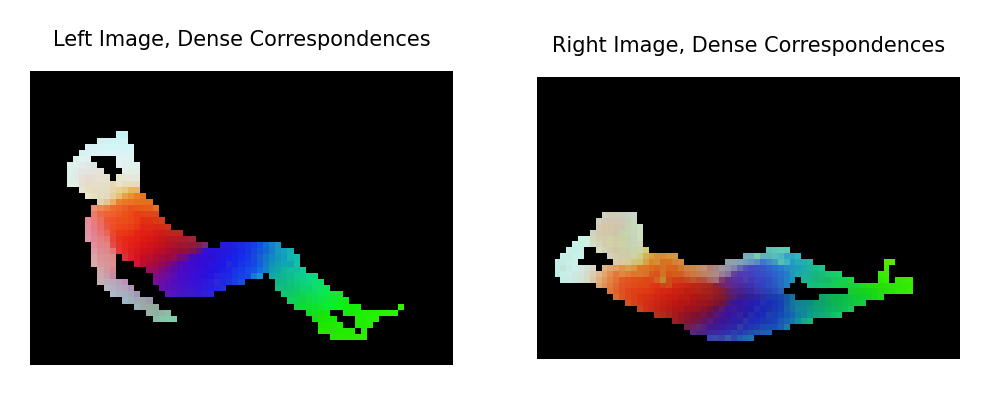

In [ ]:
# get colors for the left image
h_patches_left = patch_features[0].shape[1]
w_patches_left = patch_features[0].shape[2]
x_left = patch_features[0].view(dim, -1).permute(1, 0)
projected_image_left = torch.from_numpy(
    pca.transform(x_left.numpy())
).view(h_patches_left, w_patches_left, 3)
# multiply by 2.0 and pass through a sigmoid to get vibrant colors
projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)

# get colors for the right image
h_patches_right = patch_features[1].shape[1]
w_patches_right = patch_features[1].shape[2]
x_right = patch_features[1].view(dim, -1).permute(1, 0)
projected_image_right = torch.from_numpy(
    pca.transform(x_right.numpy())
).view(h_patches_right, w_patches_right, 3)
projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)

# apply foreground masks to both visualizations
projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD)[None, :, :]
projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD)[None, :, :]

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(projected_image_left.permute(1, 2, 0))
plt.title("Left Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(projected_image_right.permute(1, 2, 0))
plt.title("Right Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.show()

Non-stratified points: (512, 2)
Stratified points: (32, 2)


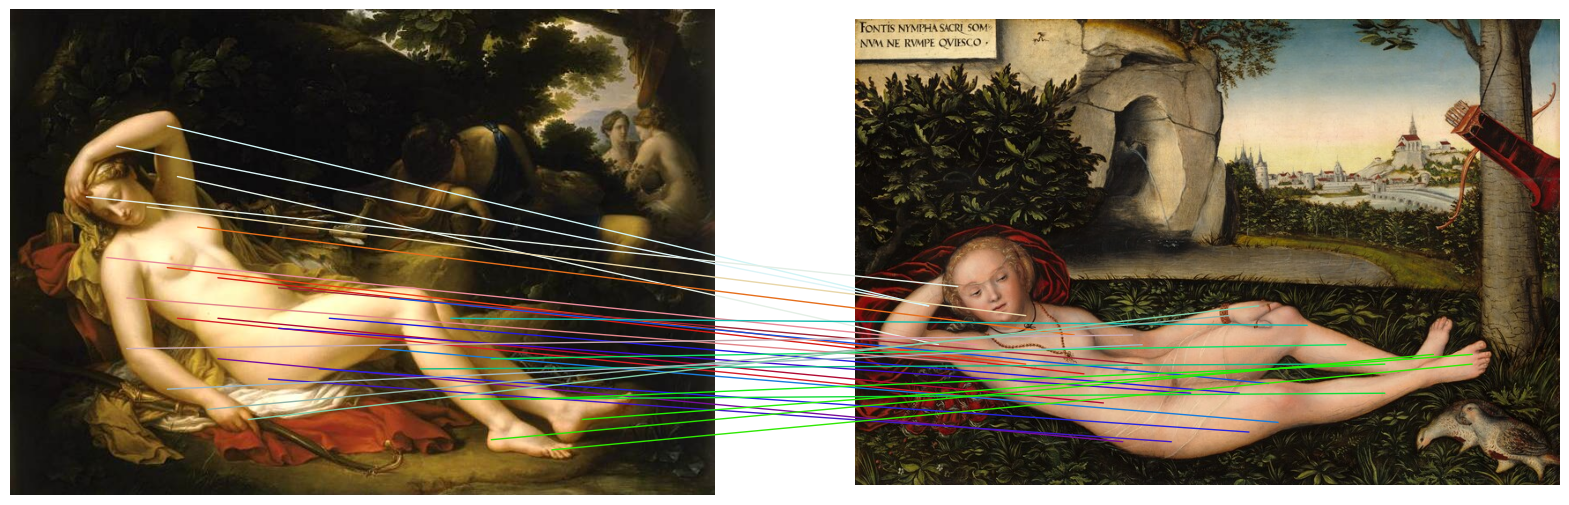

In [ ]:
# image scale to go from patches to the original image coordinates

scale_left = image_left.height / IMAGE_SIZE
scale_right = image_right.height / IMAGE_SIZE


STRATIFY_DISTANCE_THRESHOLD = 50.0

def compute_distances_l2(X, Y, X_squared_norm, Y_squared_norm):
    distances = -2 * X @ Y.T
    distances.add_(X_squared_norm[:, None]).add_(Y_squared_norm[None, :])
    return distances


def stratify_points(pts_2d: torch.Tensor, threshold: float = 100.0) -> torch.Tensor:
    # pts_2d: [N, 2]
    n = len(pts_2d)
    max_value = threshold + 1
    pts_2d_sq_norms = torch.linalg.vector_norm(pts_2d, dim=1)
    pts_2d_sq_norms.square_()
    distances = compute_distances_l2(pts_2d, pts_2d, pts_2d_sq_norms, pts_2d_sq_norms)
    distances.fill_diagonal_(max_value)
    distances_mask = torch.empty((n, n), dtype=pts_2d.dtype, device=pts_2d.device)
    torch.le(distances, threshold, out=distances_mask)
    ones_vec = torch.ones(n, device=pts_2d.device, dtype=pts_2d.dtype)
    counts_vec = torch.mv(distances_mask, ones_vec)
    indices_mask = np.ones(n)
    while torch.any(counts_vec).item():
        index_max = torch.argmax(counts_vec).item()
        indices_mask[index_max] = 0
        distances[index_max, :] = max_value
        distances[:, index_max] = max_value
        torch.le(distances, threshold, out=distances_mask)
        torch.mv(distances_mask, ones_vec, out=counts_vec)
    indices_to_exclude = np.nonzero(indices_mask == 0)[0]
    indices_to_keep = np.nonzero(indices_mask > 0)[0]
    return indices_to_exclude, indices_to_keep

print(f"Non-stratified points: {tuple(locs_2d_left_fg.shape)}")

indices_to_exclude, indices_to_keep = stratify_points(locs_2d_left_fg * scale_left, STRATIFY_DISTANCE_THRESHOLD**2)

sparse_points_left_yx = locs_2d_left_fg[indices_to_keep, :].cpu().numpy()
sparse_points_right_yx = locs_2d_right_fg[indices_to_keep, :].cpu().numpy()

print(f"Stratified points: {sparse_points_left_yx.shape}")

# show original left and right images
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(image_left)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
ax2.imshow(image_right)
ax2.set_axis_off()


for i, (row_left, col_left), (row_right, col_right) in zip(
    indices_to_keep, sparse_points_left_yx, sparse_points_right_yx
):
    row_left_orig, col_left_orig = locs_2d_left_fg[i]
    # use the color used for PCA visualization
    color = projected_image_left[
        :,
        int(row_left_orig / PATCH_SIZE),
        int(col_left_orig / PATCH_SIZE)
    ].cpu().numpy()
    con = ConnectionPatch(
        xyA=(col_left * scale_left, row_left * scale_left),
        xyB=(col_right * scale_right, row_right * scale_right),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        color=color,
    )
    ax2.add_artist(con)